<center><h1><font color="blue"> Loan Data from Prosper - Communicate Data Findings</font></h1></center>

### by Michaela C

## Introduction

#### About Prosper
Prosper was founded in 2005 as the first peer-to-peer lending marketplace in the United States. Since then, Prosper has facilitated more than $ \$19$ billion in loans to more than 1,110,000 people.<br>
Through Prosper, people can invest in each other in a way that is financially and socially rewarding. Borrowers apply online for a fixed-rate, fixed-term loan between $\$2,000$ and $\$40,000$. Individuals and institutions can invest in the loans and earn attractive returns. Prosper handles all loan servicing on behalf of the matched borrowers and investors.
More: https://www.prosper.com/about

#### About Dataset
This data set (prosperLoanData.csv) contains 113 937 loans in the period 9.11.2005 - 10.3.2014.  Dataset contains 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others. Additional explanatory file on these variables is called prosper_LoanData_explain_variables.csv and this jupyter notebook file should be distributed with it.


#### Questions for analysis

What factors affect a loan’s outcome status?


What affects the borrower’s APR or interest rate?


Are there differences between loans depending on how large the original loan amount was?


In [1]:
# imports and load data
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

import seaborn as sb

from matplotlib import rcParams

df=pd.read_csv('prosperLoanData.csv')
df_explain=pd.read_csv('Prosper Loan Data - Variable Definitions.csv')

In [2]:
df1=df.copy()

df1=df[['ListingKey','LoanOriginationDate','ClosedDate','LoanStatus','LoanOriginalAmount','Term','MonthlyLoanPayment','BorrowerAPR','LenderYield','CreditGrade','ProsperRating (Alpha)','ProsperRating (numeric)','CurrentCreditLines','OpenCreditLines','DelinquenciesLast7Years','PublicRecordsLast10Years','EmploymentStatus','EmploymentStatusDuration','StatedMonthlyIncome','AvailableBankcardCredit','TotalTrades','AmountDelinquent']]

df1.loc[:,'ClosedDate']=pd.to_datetime(df1.loc[:,'ClosedDate'])
df1.loc[:,'LoanOriginationDate']=pd.to_datetime(df1.loc[:,'LoanOriginationDate'])

borrowerEmploymentStatus = df.groupby(['EmploymentStatus'])['LoanOriginalAmount'].count().index
Empclasses = pd.api.types.CategoricalDtype(ordered=True, categories=borrowerEmploymentStatus) #alphabetical ordered
df1.loc[:,'EmploymentStatus']=df1.loc[:,'EmploymentStatus'].astype(Empclasses)

CreditGrade = df.groupby(['CreditGrade']).count().index
credit = pd.api.types.CategoricalDtype(ordered=True, categories=CreditGrade) 
df1.loc[:,'CreditGrade']=df1.loc[:,'CreditGrade'].astype(credit)

index_names= ['HR','E','D','C','B','A','AA']
rating = pd.api.types.CategoricalDtype(ordered=True, categories=index_names) 
df1.loc[:,'ProsperRating (Alpha)']=df1.loc[:,'ProsperRating (Alpha)'].astype(rating)

df1.rename(columns={'ProsperRating (Alpha)':'ProsperRating'}, inplace=True)

df1['TotalCreditLines'] = df1['CurrentCreditLines'] + df1['OpenCreditLines']

df1.drop(['CurrentCreditLines', 'OpenCreditLines'], axis=1, inplace = True)


**I created 4 loan groups based on ther LoanOriginalAmount called df1_loan1, df1_loan2, df1_loan3,df1_loan4.  LoanOriginalAmount limits are 10000 for df1_loan1, 20000 for df1_loan2, 30000 df1_loan3 and higher than 30000 is represented in df1_loan4 groups.**

In [3]:
df1_loan1=df1[df1['LoanOriginalAmount']<10000]
df1_loan2=df1[(df1['LoanOriginalAmount']>10000) & (df1['LoanOriginalAmount']<20000)]
df1_loan3=df1[(df1['LoanOriginalAmount']>20000) & (df1['LoanOriginalAmount']<30000)]
df1_loan4=df1[(df1['LoanOriginalAmount']>30000) ]


**df1_sub: dataframe where only most frequent loans statuses are included **
**df1_sub2: dataframe where the loan length is included**

In [4]:

df1_sub2=df1.copy()
df1_sub2['DateDiff']=df1_sub2['ClosedDate']-df1_sub2['LoanOriginationDate']


def strfdelta(tdelta, fmt):
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

DateDiff_int=[]
for item in df1_sub2.DateDiff:
    DateDiff_int.append(strfdelta(item, "{days}"))
    
df1_sub2['DaysLoan']=DateDiff_int    

df1_sub2.drop(df1_sub2[df1_sub2['DaysLoan']=="nan"].index, axis=0, inplace=True)

df1_sub2['DaysLoan']=df1_sub2['DaysLoan'].astype(np.int64)

df1_sub2.drop(df1_sub2[df1_sub2['DaysLoan']<0].index, axis=0, inplace=True)

df1_sub2['StatedMonthlyIncome'].fillna(df1_sub2['StatedMonthlyIncome'].mean(), inplace=True)

df1_sub2['LoanOriginalAmount'].fillna(df1_sub2['LoanOriginalAmount'].mean(), inplace=True)

cat_var1=['Current', 'Completed', 'Chargedoff','Defaulted']

df1_sub=df1[df1['LoanStatus'].isin(cat_var1)]

<center><h2><font color="blue"> What factors affect a loan’s outcome status?</font></h2></center>

What is the percentage of each category in Loan Status?

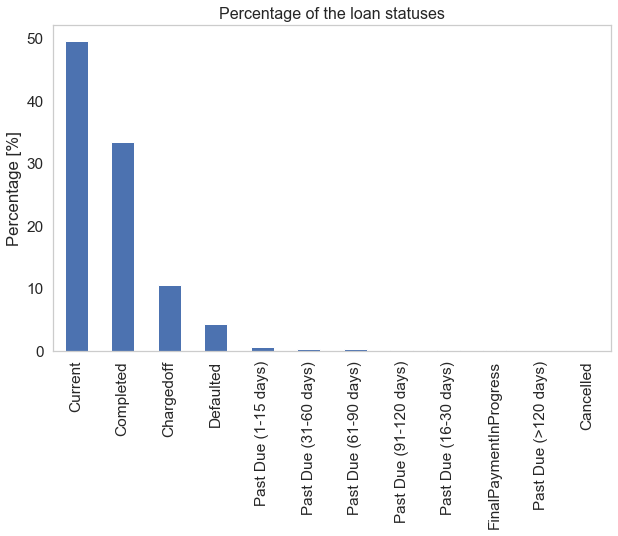

In [22]:
plt.figure(figsize=[10,6]);
xx=df1['LoanStatus'].value_counts(normalize=True)*100
xx.plot(kind="bar");
plt.ylabel('Percentage [%]');
plt.grid(False);
plt.title('Percentage of the loan statuses', fontsize=16);

Observation: The visible proportions are for the categories Current, Completed, Chargedoff and Defaulted.

What are the counts of prosper ratings in most frequent loan status categories?

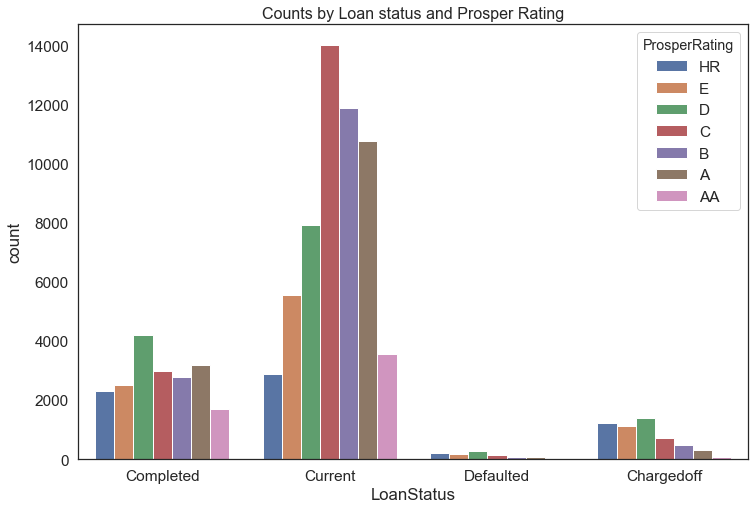

In [25]:
plt.figure(figsize = [12, 8])
sb.set(font_scale = 1.4)
sb.set_style(style='white') 
ax=sb.countplot(x="LoanStatus",hue='ProsperRating', data=df1_sub);
ax.set_title('Counts by Loan status and Prosper Rating', fontsize=16);

Observation: We can see that in the group with Current LoanStatus, the most frequent is the C ProsperRating. For the Completed, Defaulted and Chargedoff it is D ProsperRating. 

What are mean Amount Delinquents for each loan status prosper ratings?

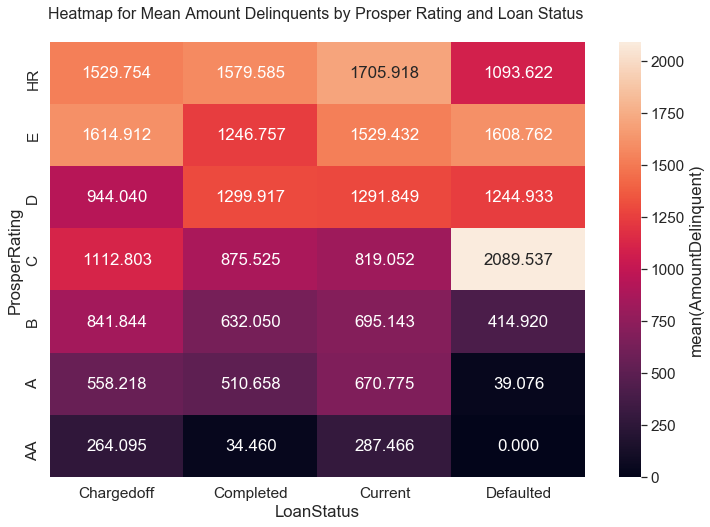

In [34]:
plt.figure(figsize = [12, 8])

cat_means = df1_sub.groupby(['LoanStatus', 'ProsperRating']).mean()['AmountDelinquent']
cat_means = cat_means.reset_index(name = 'AmountDelinquent')

cat_means = cat_means.pivot(index = 'ProsperRating', columns = 'LoanStatus',
                            values = 'AmountDelinquent')
ax=sb.heatmap(cat_means, annot = True, fmt = '.3f',
           cbar_kws = {'label' : 'mean(AmountDelinquent)'});
ax.set_title('Heatmap for Mean Amount Delinquents by Prosper Rating and Loan Status \n', fontsize=16);

Observation: From the above heatmap, we can see, that the group with the highest mean AmountDelinquent is the group with Prosper Rating C and Loan Status Defaulted. Groups with higher rating (AA, A) have the lovest mean Amount Delinquent. Borrowers whose loans are charged-off have the highest mean Amount Delinquent compare to borrowers with the other loan status. 

What is the mean Loan Original Amount for each of the prosper ratings in loan status category?

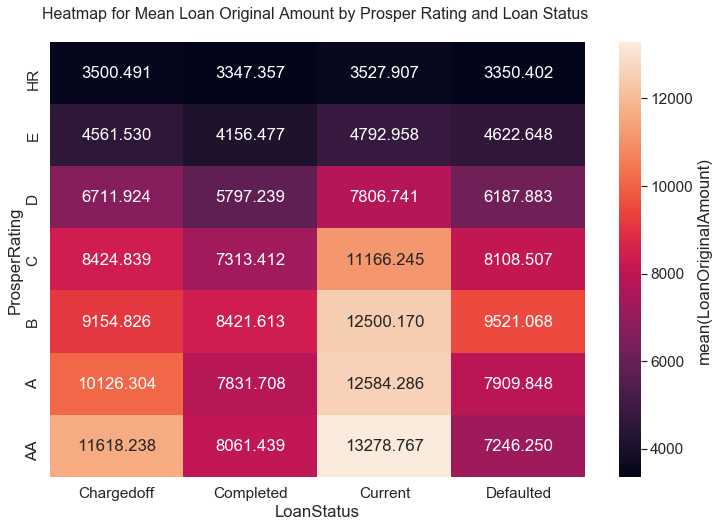

In [35]:
plt.figure(figsize = [12, 8])

cat_means = df1_sub.groupby(['LoanStatus', 'ProsperRating']).mean()['LoanOriginalAmount']
cat_means = cat_means.reset_index(name = 'LoanOriginalAmount')

cat_means = cat_means.pivot(index = 'ProsperRating', columns = 'LoanStatus',
                            values = 'LoanOriginalAmount')
ax=sb.heatmap(cat_means, annot = True, fmt = '.3f',
           cbar_kws = {'label' : 'mean(LoanOriginalAmount)'});
ax.set_title('Heatmap for Mean Loan Original Amount by Prosper Rating and Loan Status \n', fontsize=16);

Observation:From the about heatmap we cans that highest mean Loan Original Amounts have the borrowers with the loan status Current and with highest ratings (AA, A, B). The second group with the highest mean Loan Original Amount is the "charged-off" group.

What is the mean Stated Monthly Income for each of the prosper ratings in loan status category?

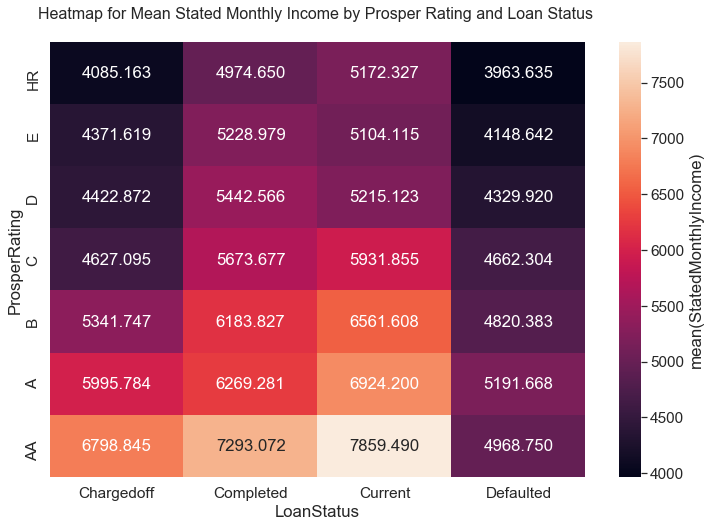

In [36]:
plt.figure(figsize = [12, 8])

cat_means = df1_sub.groupby(['LoanStatus', 'ProsperRating']).mean()['StatedMonthlyIncome']
cat_means = cat_means.reset_index(name = 'StatedMonthlyIncome')

cat_means = cat_means.pivot(index = 'ProsperRating', columns = 'LoanStatus',
                            values = 'StatedMonthlyIncome')
ax=sb.heatmap(cat_means, annot = True, fmt = '.3f',
           cbar_kws = {'label' : 'mean(StatedMonthlyIncome)'});
ax.set_title('Heatmap for Mean Stated Monthly Income by Prosper Rating and Loan Status \n', fontsize=16);

Observation: We can see that borrowers with the highest incomes belong to the LoanStatus groups Current and then Completed. Status Defaulted have borrowers with the lowest incomes.

<center><h2><font color="blue"> What affects the borrower’s APR or interest rate? </font></h2></center>


In [39]:
num_vars = ['LoanOriginalAmount', 'BorrowerAPR', 'AvailableBankcardCredit']

Which variables correlated most with Borrower APR?

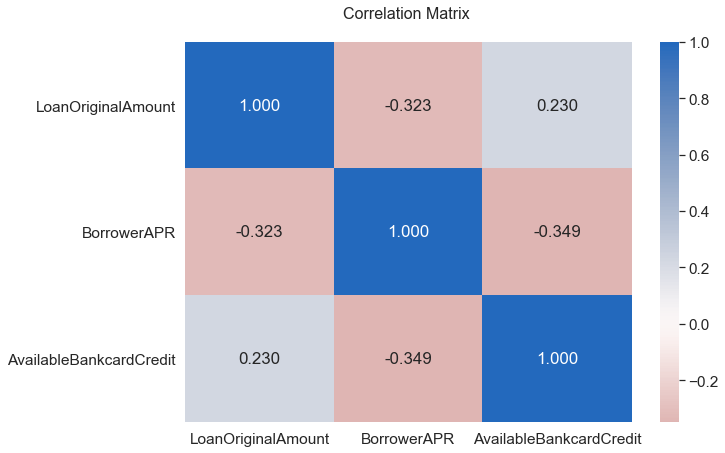

In [41]:
# correlation matrix
plt.figure(figsize = [10, 7])
ax=sb.heatmap(df1[num_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0);
ax.set_title('Correlation Matrix \n', fontsize=16);

Observation: We can see that there is a weak negative correlation between BorrowerAPR and LoanOriginalAmount and AvailableBankCredit. Other variables in df1 have  even lower correlations coefficients with Borrower APR. 

Since variables BorrowerAPR and LenderYield have very similar distributions, what is the correlation coefficient between these 2 numerical variables?

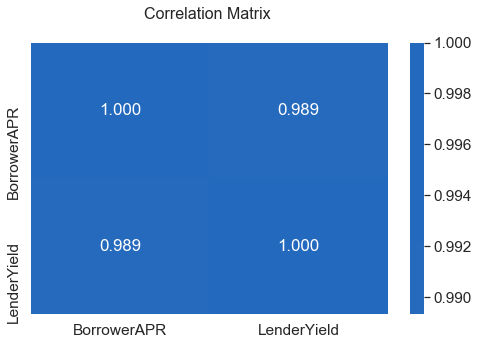

In [56]:
ax.set_title('Correlation Matrix \n', fontsize=16);
num_vars = ['BorrowerAPR', 'LenderYield']
# correlation plot
plt.figure(figsize = [8, 5])
ax=sb.heatmap(df1[num_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0);
ax.set_title('Correlation Matrix \n', fontsize=16);

Observation: There is a strong correlation between Borrowers APR and Lender Yield. This  confirms that a lender will earn the most on people with lower higher Borrower APR.

Can you show correlation plots of Borrower APR - Lender Yield and Borrower APR - Prosper Rating? Numerical variables are Borrower APR and Lender Yield, while Prosper Rating is a categorical Ordinal variable. 

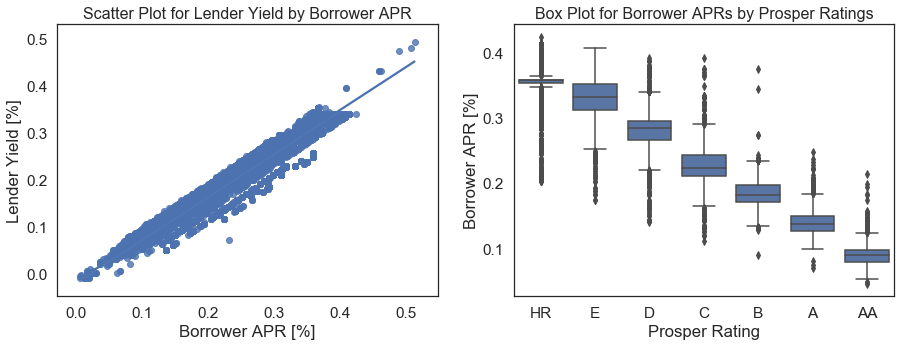

In [57]:
sb.set_style(style='white') 
base_color = sb.color_palette()[0]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
ax=sb.regplot(ax=axes[0], data = df1, x = 'BorrowerAPR', y = 'LenderYield');
ax1=sb.boxplot(ax=axes[1], x='ProsperRating', y='BorrowerAPR', data=df1, color=base_color);
ax.set(xlabel='Borrower APR [%]', ylabel='Lender Yield [%]');
ax1.set(xlabel='Prosper Rating', ylabel='Borrower APR [%]');
ax.set_title('Scatter Plot for Lender Yield by Borrower APR', fontsize=16);
ax1.set_title('Box Plot for Borrower APRs by Prosper Ratings', fontsize=16);


Observation: Borrowers with higher Prosper Rating have lower APR. There is a strong correlation between Borrowers APR and Prosper Rating score. There is also a strong correlation between borrower APR and LenderYield. That indicates that lender will earn the most on people with lower ratings.

Are there some differencies in Borrower APR in terms of borrower loan Terms for each of the Prosper Ratings Categories?

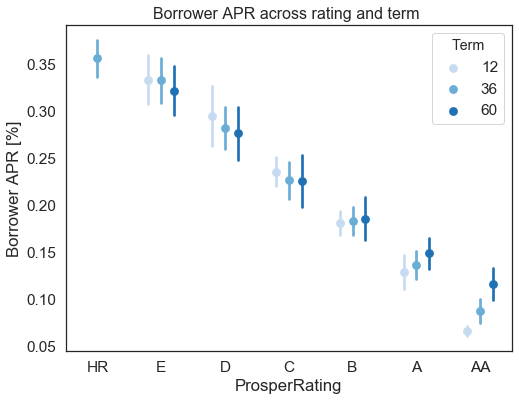

In [58]:
fig = plt.figure(figsize = [8,6])
sb.set(font_scale = 1.4)
sb.set_style(style='white') 

ax = sb.pointplot(data = df1, x = 'ProsperRating', y = 'BorrowerAPR', hue = 'Term',
           palette = 'Blues', linestyles = '', dodge = 0.4, ci='sd')
ax.set_title('Borrower APR across rating and term ', fontsize=16);
ax.set_ylabel('Borrower APR [%]');
ax.set_yticklabels([],minor = True);

Observation: Interestingly, the borrower APR decrease with the increase of borrow term for people with HR-C ratings. But for people with B-AA ratings, the APR increase with the increase of borrow term.

<center><h2><font color="blue"> Are there differences between loans depending on how large the original loan amount was?</font></h2></center>

How do differentiate groups with different Loan Original Amounts in terms of Loan Duration?

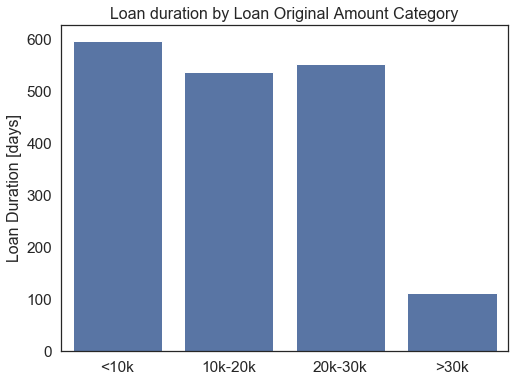

In [59]:
plt.figure(figsize=(8,6))
sb.set(font_scale = 1.4)
sb.set_style("white")
y=[strfdelta((df1_loan1['ClosedDate']-df1_loan1['LoanOriginationDate']).mean(),"{days}"),strfdelta((df1_loan2['ClosedDate']-df1_loan2['LoanOriginationDate']).mean(),"{days}"), strfdelta((df1_loan3['ClosedDate']-df1_loan3['LoanOriginationDate']).mean(),"{days}"),strfdelta((df1_loan4['ClosedDate']-df1_loan4['LoanOriginationDate']).mean(),"{days}")]
x=["<10k","10k-20k","20k-30k", ">30k"]
ax=sb.barplot(x,y, color=base_color);
ax.set_title('Loan duration by Loan Original Amount Category', fontsize=16)
ax.set_ylabel('Loan Duration [days]',fontsize=16);
ax.grid(False);



Observation: Plot about shows that the borrowers with the highest LoanOriginalAmount have the shortest period between LoanOriginationDate and ClosedDate.

If I plot Loan Original Amounts across the Loan Length, is there any differencies for Loan Status?

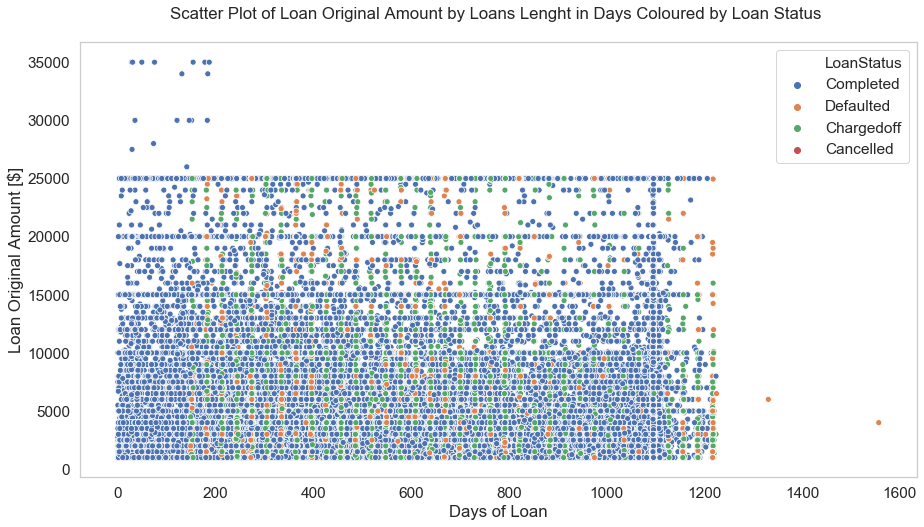

In [62]:
plt.figure(figsize=[15, 8])
sb.set(font_scale = 1.4)
sb.set_style("whitegrid")
ax=sb.scatterplot(data = df1_sub2, x = 'DaysLoan', y = 'LoanOriginalAmount', hue="LoanStatus");
ax.set_xlabel('Days of Loan');
ax.set_ylabel('Loan Original Amount [$]');
ax.set_title('Scatter Plot of Loan Original Amount by Loans Lenght in Days Coloured by Loan Status \n', fontsize=16)
ax.grid(False)


Observation: Here we present only Completed loans with defined DateClosed. Plot above shows that the highest LoanOriginalAmounts (>\$25000) are completed within ca. 200 days. The longest loans are for the group Defaulted. For loans shorter than 1 year, the most frequent loan status is Completed.

What subgroups of the Loan Original Amount vs. Stated Monthly Income are the most populated?

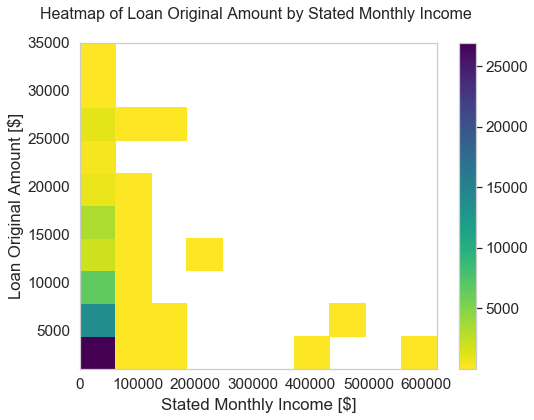

In [65]:
plt.figure(figsize=[8, 6])
sb.set(font_scale = 1.4)
sb.set_style("whitegrid")
plt.hist2d(data = df1_sub2, x = 'StatedMonthlyIncome', y = 'LoanOriginalAmount', cmin=0.5, cmap='viridis_r')
plt.colorbar()
plt.xlabel('Stated Monthly Income [$]')
plt.ylabel('Loan Original Amount [$]');
plt.title('Heatmap of Loan Original Amount by Stated Monthly Income \n', fontsize=16);

Observation: In this plot we can see that most of borrowers have salaries in range  \\$0-50000   and LoanOriginalAmount is less than  $5000 


<center><h2><font color="blue">Main findings</font></h2></center>

<center><h3><font color="blue"> What factors affect a loan’s outcome status?</font></h3></center>


<ol>
    <li>The most populated categeries of loan status are Current, Completed, Chargedoff and Defaulted.</li>
    <li>For the group with Current loan status, the most frequent is the C prosper rating. For the Completed, Defaulted and Chargedoff it is D prosper rating. </li>
    <li>The group with the highest mean amount delinquent is the group with prosper rating C and loan status Defaulted. Groups with higher rating (AA, A) have the lowest mean amount delinquent. </li>
    <li>Highest mean loan original amounts have the borrowers with the loan status Current and with highest ratings (AA, A, B). The second group with the highest mean loan original amount is the "charged-off" group.</li>
<li> Borrowers with the highest incomes belong to the loan status Current. Loan status Defaulted have borrowers with the lowest incomes.</li>

</ol>

<center><h3><font color="blue"> What affects the borrower’s APR or interest rate? </font></h3></center>

<ol>
    <li>BorrowerAPR is strongly negatively correlated with ProsperRating and positevely correlated with lender yield. It means that borrowers with the lowest rating have the highest interest rate (APR) and the lender have higher interest on lowest rated borrowers.</li>
    <li>Correlation between Borrower APR and loan original amount is -0.302 - which indicates a weak negative correlation.This means that there are also other factors which determine the value of BorrowerAPR.</li>
    <li>Correlation between Borrower APR and AvailableBankCredit is 0.230 - which indicates a weak positive correlation.This means that there are also other factors which determine the value of BorrowerAPR.</li>
    <li>The borrower APR decrease with the increase of borrow term for people with HR-C ratings. But for people with B-AA ratings, the APR increase with the increase of borrow term.</li>
</ol>    

<center><h3><font color="blue"> Are there differences between loans depending on how large the original loan amount was?</font></h3></center>

<ol>
    <li> The highest loan original amounts (>$25000) are paid by borrowers within ca. 200 days. According to the previous findings, these borrowers have also the highest ratings (AA, A, B).</li> 
    <li>The longest loans are Defaulted loans. According to the previous findings, these borrowers have the lowest inomes of all loan status categories.</li>
    <li>The most of borrowers have salaries in range  \$0-50000  and the most common loan original amount is less than  \$5000. </li>
    
</ol>    

<h2> Sources</h2>

https://github.com/yduan004/communicate-data-loan-data-from-Prosper/blob/master/exploration.ipynb
https://stackoverflow.com/questions/8906926/formatting-timedelta-objects
https://stackoverflow.com/questions/54835464/draw-box-around-seaborn-facetgrid-axes